# Uncovering Structure in Data

Data can be hard to understand sometimes. We can picture it in 2 dimensions, and maybe 3 dimensions, if we use graphs. But what about in higher dimensions? In this case we might want to view our data in a lower dimension without losing too much information. Or, we want to uncover structure that we suspect might be there. In this case, the structure might be smaller groupings of the data where similar observations are grouped together.

In this lesson we'll cover two approaches that can help us better understand our data by uncovering structure. These two methods are:
1. Hierarchical Clustering (HCL)
    * Given observation described by features, it is common to want similar features to be grouped together.
    * Sometimes we have an idea of what the structure should be, but we don't always know how to get there. HCL doesn't require us to specify what the structure is beforehand.
2. Principal Component Analysis (PCA)
    * Finds a low-dimensional representation that can allow us to view the data and observe structure
    * Balances low-dimensional representation without losing too much information
    
## Features
What do I mean when I talk about observation being described by features? Here, I mean that an observation is represented by a list (or an array/vector in other terms) of numbers.

### Note
Many of my images will be drawn from this [book](https://people.unica.it/claudioconversano/files/2015/02/ISLR_print4.pdf). I highly recommend reading it if you're interested in more details.

## Libraries Needed
Please run this code as soon as you can. Any issues here are usually just install issues, and though annoying can take time to solve.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn import decomposition
from matplotlib.colors import ListedColormap


In [2]:
example_observation = [1, 2, 0, 0, 0.5, 0.24]

The above example is an observation with 6 features, ie 6 dimensions.

If we stack these observations on top of each other we'd have a list of lists, or a matrix, where each observation is represented by a row, and each row has 6 elements.

In [3]:
example_observation_1 = [1, 2, 0, 0, 0.5, 0.24]
example_observation_2 = [1, 3, 1, 0, 0.75, 0.9]
stacked_observations = [example_observation_1, example_observation_2]

In [4]:
print(stacked_observations)

[[1, 2, 0, 0, 0.5, 0.24], [1, 3, 1, 0, 0.75, 0.9]]


In [5]:
matrix_observations = np.array(stacked_observations)

In [6]:
print(matrix_observations)
print("The shape of our matrix is", matrix_observations.shape)

[[1.   2.   0.   0.   0.5  0.24]
 [1.   3.   1.   0.   0.75 0.9 ]]
The shape of our matrix is (2, 6)


But what do these features mean? Well, that depends on our data.

1. Text data
    * Each observation could be a document.
    * Each element in our feature list for a document might be a whole number, representing he number of times a word appears in that document.
2. Disease codes
    * Each observation is a patient.
    * Each element in our feature list might be the presence of a disease code, the value for a labratory test, a vital sign value, etc.

## Hierarchical Clustering
Hierarchical clustering is an appraoch the builds an upside down tree of relationships between observations. This is known as a dendrogram.

That's a little bit confusing. Sometimes an example can help!
Below is an example of 2 dimensional data in a flat representation. What might this look like as a dendrogram?

<img src="img/example_2d_data.png" alt="flat_2d_cluster" style="width: 500px;"/>
An example of data points in a flat clustering representation


<img src="img/dendrogram_1.png" alt="dendrogram_no_cut" style="width: 500px;"/>
The flat data represented as a dendrogram. Notice that there aren't  any clusters just yet.


So, how do we interpret this dendrogram?
* The observations along the bottom are known as leaves. 
* As we move up, we begin to fuse leaves. These are known as subgroups or clusters.
* The earlier these fusions happen the more similar those observations are than leaves which were fused later.
    * Be careful with spatial interpretations. Height matters, but distance along the x axis does not. 




<img src="img/dendrogram_cuts_cropped.png" alt="dendrogram_cut" style="width: 2000px;height: 400px;"/>
By choosing the point on a point on the y axis we can choose what clusters we wantto create


One thing you might notice is that there aren't any clusters even though we've induced some kind of structure. In order to identify clusters from the structure we need to choose where to "cut" along the y axis.

The y axis represents how close observations are, as in the lower on the y axis leaves are fused the more similar they are.

Next you might ask how do we measure how similar or close leaves are? How does that apply to groups of leaves?

### Measures of distance
Recall that we're working with observation that are represented as lists of numbers. We can measure how close or similar these observations are to one another using these features.

Many distance measurs exist. Examples include:
* Euclidean distance
    * A measure which looks at the distance between each corresponding feature in two lists of features.
    * d(p,q) = $\sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2}$
    * A standard measure that is used, but can weigh certain features more than others if they are big.
* Cosine distance
    * Measures the cosine of an angle between two lists of features
    * Usually a safe measure, unless you care about how "big" feature lists are.
    * Technically the distance is 1 - cos(angle between lists of features)
* Jaccard distance
    * A measure for looking at set similarities. Perfect for binary lists.
    * Only works if you're looking at sets, ie an object is in a set or it's not.
    * Technically the distance is 1 - jaccard similarity.
    
Overall, the distance measure matters a great deal for HCL, and in general

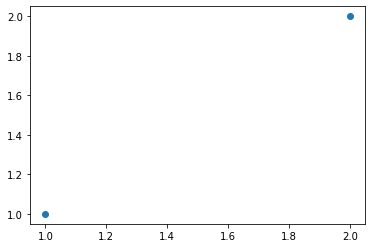

In [30]:
X = np.array([[1,1], [2,2]])
plt.scatter(X[:,0], X[:,1])
plt.show()

In [31]:
X

array([[1, 1],
       [2, 2]])

### Exercise: Calculate the distance between the two points using two three different distance measures
[pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) is a good function to calculate distances. Look at the documentation and see how you might use it.

In [33]:
pdist(X, metric = "euclidean")

array([1.41421356])

In [34]:
pdist(X, metric = "cosine")

array([2.22044605e-16])

### Clustering Algorithm

1. Begin with all $n$ observations and a distance/dissimilarity measure. 
2. Measure the distance between all observations, treating each observation as its own cluster.
3. For $i = n, n-1, n-2, ... 2$:
    * (a) Examine all the inter-cluster distances among the $i$ clusters. Fuse the two clusters that are most similar. The distance between these two clusters indicates the height (yaxis) in the dendrogram to place this merge. 
    * (b) Compute the new pairwise distance among the remaining clusters (including the fused cluster).

## How do we measure the distance between clusters?
Measuring the distance when each "cluster" has only one observation is fairly intuitive. But when these clusters contain multiple observations we have to get a little fancy. Here are examples of how to measure the distance between clusters.

* Complete (maximum distance)
    * Computer all pairwise distances between the observation in two clusters and take the *largest* distance.
* Single (minimum distance)
    * Computer all pairwise distances between the observation in two clusters and take the *smallest* distance.
* Average
    * Computer all pairwise distances between the observation in two clusters and take the *average* distance.

### Coding Example

#### Load data

In [9]:
data_path = "data/All_taxa.csv"
# data_path = "data/Fungi.csv"
# data_path = "data/Bacteria.csv"
# data_path = "data/Protist.csv"
# data_path = "data/Archaea.csv"
data_df = pd.read_csv(data_path, skiprows=[0])
data_df = data_df.transpose()
data_df = data_df.rename(columns=data_df.iloc[0])
data_df = data_df.drop(labels = "Location", axis = "index")
new_index_names = ["cattle_0", "cattle_1", "cattle_2", "cattle_3", "cattle_4",
                      "hay_5", "hay_6", "hay_7", "hay_8", "hay_9"]
data_df.index = new_index_names

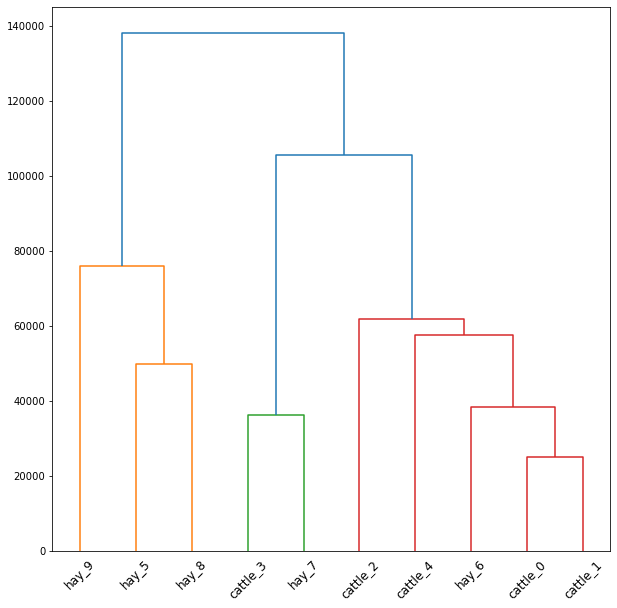

In [12]:
Z = hierarchy.linkage(y = data_df, metric = "euclidean", method = 'average')
plt.figure(figsize=(10, 10))
dn = hierarchy.dendrogram(Z,  labels = data_df.index.values, leaf_rotation = 45)

## Exercise: Experiment with different distance metrics and cluster distance metrics

Try some different distance metrics and cluster distance metrics. Look at the documentation for [scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) to see how you can change these arguments. Try reading in different sample data and seeing how the dendrogram changes. **Do you need to perform any transformations on the data we did before?**

## Principal Component Analysis
Recall that we needed clustering in the first place because there are times when our data is in too high of a dimension for us to visualize it. Even though we wanted to uncover structure, or confirm structure which should be there, we couldn't without HCL. 


1. Principal Component Analysis (PCA) can allow us to reduce dimensions down to two or three which allows us to visualize it easier.
2. Even if we don't want to visualize the data in lower dimensions, we might want to represent observations with their most important features.
3. PCA allows us to reduce dimensionality while maintaining the underlying structure of the data.

### What is PCA?
I'm going to do a lot of handwaving here,  but PCA is essentially a method to find a low-dimensional representation that conatins as much variation from the original data as possible.

What do we mean by variation? Basically, some dimensions of the data are not as "interesting" as others, where interesting is a measure for how much the observations vary along this dimension. Note that these dimensions are not the original dimensions of the data and are new ones.

Let's interpret this toy example. [source](https://towardsdatascience.com/principal-components-analysis-explained-53f0639b2781)

<img src="img/PCA_example.png" alt="PCA_interp" style="width: 2000px;height: 400px;"/>


Generally speaking, it's difficult to interpret these directions and is subjective. Once we perform this transformation on the data, the individual features lose their meaning.

### Coding Example

In [2]:
data_path = "data/All_taxa.csv"
# data_path = "data/Fungi.csv"
# data_path = "data/Bacteria.csv"
# data_path = "data/Protist.csv"
# data_path = "data/Archaea.csv"
data_df = pd.read_csv(data_path, skiprows=[0])
data_df = data_df.transpose()
data_df = data_df.rename(columns=data_df.iloc[0])
data_df = data_df.drop(labels = "Location", axis = "index")
new_index_names = ["cattle_0", "cattle_1", "cattle_2", "cattle_3", "cattle_4",
                      "hay_5", "hay_6", "hay_7", "hay_8", "hay_9"]
data_df.index = new_index_names

In [3]:
pca = decomposition.PCA(n_components=2)
pca.fit(data_df)
X = pca.transform(data_df)
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]




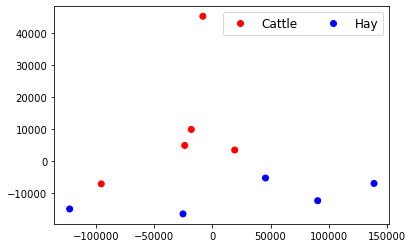

In [4]:
# 2 dimensional PCA decomposition
colormap = ListedColormap(["r","b"])
classes = ['Cattle', 'Hay']
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap = colormap)
plt.legend(handles=scatter.legend_elements()[0],
           labels=classes,
           loc='upper right',
           ncol=3,
           fontsize=12)
plt.show()

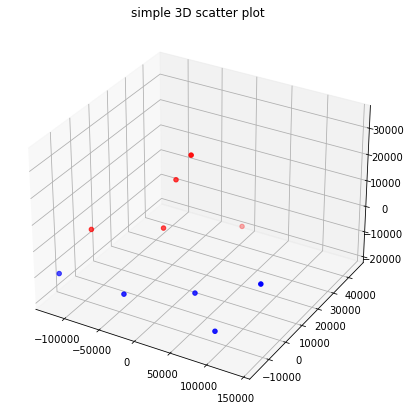

In [5]:
# 3 dimensional PCA decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(data_df)
X = pca.transform(data_df)
y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, cmap = colormap)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

### Exercise: Edit some of the plot parameters
This is more of an exercise in presentation. Can you change the of the points? Change the titles and labels for the plot?

## Accuracy vs Precision
Let's say that we have a quantity that we're trying to measure. Here, the quantity is some measurable phenomenon like the temperature of a glass of water or oxygen content in a patient's blood. We have repeated measuremens of this quantity. Following the previous examples this might be thermometers in the water, or a pulse oximeter. We can define two measurements of good observations.
1. Accuracy
    * Measures the difference between the average of our observations and the true value of the random variable being measured.
    * Accuracy tells us about systematic errors, or errors that come from our ability to measure the quantity well (Imagine a broken thermometer)
    * To measure accuracy we would need a reference value. If we knew the true value of the quantity we were tryingto measure we wouldn't be measuring it. A reference value allows us to calibrate the measurement tools.
2. Precision
    * Measures how close the observations are to each other.
    * Precision tells us about random errors, orthe variability of the quantity being measured.
    
All in all, we can think of accuracy as telling us how far away our measurements are from the true value, and precision as the spread or variability of our data. These two values tell us how good our measurements are.

### Coding Example
Let's say we want to measure a quantity that is centered around the value 5. Let's draw some measurements.

### Small example where things go well

In [38]:
measurements = np.random.normal(loc = 5, scale = 0.1, size = 10)
print(measurements)
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))

[5.15685609 4.99106584 4.92843451 5.03456736 4.81960055 4.98195018
 5.08001189 4.8030119  5.05193162 5.01478994]

Mean: 4.986221986861847

Standard deviation: 0.10492542382799877


### Small example where precision is bad


In [40]:
measurements = np.random.normal(loc = 5, scale = 10, size = 10)
print(measurements)
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))

[11.45183241 25.49571501  8.95439787 -2.36777339 13.3067098   6.18786554
  7.30484531  2.67857306 -8.82889423 24.51487252]

Mean: 8.869814389891886

Standard deviation: 10.173738450847742


In [42]:
measurements = np.random.normal(loc = 5, scale = 10, size = 100)
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 3.5277590226257747

Standard deviation: 10.51907879561919


In [43]:
measurements = np.random.normal(loc = 5, scale = 10, size = 1000)
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 4.907662584982796

Standard deviation: 9.978808882637493


### Small example where accuracy is bad

In [44]:
measurements = np.random.normal(loc = 5, scale = 10, size = 1000) + 0.1
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 4.897990230086387

Standard deviation: 9.817611797097731


In [46]:
measurements = np.random.normal(loc = 5, scale = 10, size = 1000) + 2
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 7.1889594254805145

Standard deviation: 10.357098377820902


In [47]:
measurements = np.random.normal(loc = 5, scale = 10, size = 5000) + 2
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 7.161495753387416

Standard deviation: 9.859012906548509


In [48]:
measurements = np.random.normal(loc = 5, scale = 10, size = 10000) + 2
print("\nMean: {}".format(np.mean(measurements)))
print("\nStandard deviation: {}".format(np.std(measurements)))


Mean: 7.029972994120448

Standard deviation: 10.045884203052255


## Bootstrapping
One issue we might run into is randomness or noise in our data. This is a normal occurence in data collection, even with the most strict and best tools. Noise impacts our analysis by questioning whether we can trust our clusters. Maybe we got a few observations that make it look like there is structure when there really isn't. So how can we address this?

One way to address noise in your analysis is to use bootstrapping. Bootstrapping is a resampling technique that mimicks the original sampling process and allowing us to generate multiple datasets from the original dataset. In our case, this allows us to generate multiple clusters to assess stability of our cluster assignments.

Bootstrapping works by 
1. Sample with replacement n observations from a dataset of size n
2. Calculate your statistic of interest (clustering assignments, mean, variance, etc)
3. Repeat h times. h is usually a large number like 500 or 1000 in my experience.

In [24]:
X = np.random.normal(loc = 5, scale = 3, size = 10)
X[0] = 20
X[1] = 15
print("\nMean: {}".format(np.mean(X)))
print("\nStandard deviation: {}".format(np.std(X)))



Mean: 7.1803507268982445

Standard deviation: 5.705405905299984


In [25]:
# Bootstrap the data

mean_list = []
stdev_list = []
for i in range(5000):
    X_bootstrap = np.random.choice(X, size = len(X), replace = True)
    mean_list.append(np.mean(X_bootstrap))
    stdev_list.append(np.std(X_bootstrap))
print("\nbootstrap Mean: {}".format(np.mean(mean_list)))
print("\nbootstrap Standard deviation: {}".format(np.mean(stdev_list)))


bootstrap Mean: 7.164344004646377

bootstrap Standard deviation: 5.190570042567543


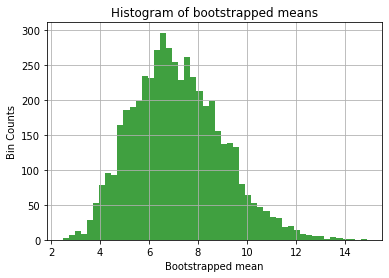

In [26]:
# Plot the bootstrap means

n, bins, patches = plt.hist(mean_list, 50, density=False, facecolor='g', alpha=0.75)


plt.xlabel('Bootstrapped mean')
plt.ylabel('Bin Counts')
plt.title('Histogram of bootstrapped means')
plt.grid(True)
plt.show()